# Baseline Model Training (Time-Based Split)
This notebook trains a baseline binary classifier to predict whether a user will give a **high rating** (rating ≥ 4).

**Key constraint:** all evaluation is **time-based** to avoid leakage (train on past, validate/test on future).


## 0) Imports
We keep imports at the top for reproducibility.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from xgboost import XGBClassifier

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)
import joblib


## 1) Load prepared datasets
We load the precomputed, leakage-safe features saved from the feature engineering notebook:
- `train_prepared.parquet`
- `val_prepared.parquet`
- `test_prepared.parquet`


In [2]:
train = pd.read_parquet("../data/processed/train_prepared.parquet")
val   = pd.read_parquet("../data/processed/val_prepared.parquet")
test  = pd.read_parquet("../data/processed/test_prepared.parquet")

print("Rows:", {"train": len(train), "val": len(val), "test": len(test)})
train.head()


Rows: {'train': 4490259, 'val': 599327, 'test': 846774}


,userId,movieId,rating,timestamp,timestamp_dt,high_rating,user_mean_rating,user_like_rate,user_n_ratings,movie_mean_rating,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,348,6163,4.0,01-01-2008,2008-01-01,1,4.0,1.0,1,4.000000,...,0,0,0,0,0,1,0,1,0,0
1,348,45722,4.0,01-01-2008,2008-01-01,1,4.0,1.0,2,3.884615,...,0,0,0,0,0,0,0,0,0,0
2,348,53125,4.0,01-01-2008,2008-01-01,1,4.0,1.0,3,4.000000,...,0,0,0,0,0,0,0,0,0,0
3,348,54259,4.0,01-01-2008,2008-01-01,1,4.0,1.0,4,4.000000,...,0,0,0,0,0,1,0,0,0,0
4,359,316,4.0,01-01-2008,2008-01-01,1,4.0,1.0,1,3.337838,...,0,0,0,0,0,0,1,0,0,0


## 2) Define features and target
We use a minimal set of user/movie historical aggregates plus a static movie feature (`year`).
This is intentionally small to get a fast and interpretable baseline.

In [5]:
metadata = ['userId', 'movieId', 'rating', 'timestamp', 'timestamp_dt', 'high_rating']

In [6]:
feature_cols = [f for f in train.columns if f not in metadata]

target_col = "high_rating"

X_train, y_train = train[feature_cols], train[target_col]
X_val,   y_val   = val[feature_cols],   val[target_col]
X_test,  y_test  = test[feature_cols],  test[target_col]

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("Positive rate (train/val/test):",
      y_train.mean().round(4), y_val.mean().round(4), y_test.mean().round(4))


X_train: (4490259, 27) y_train: (4490259,)
Positive rate (train/val/test): 0.4853 0.5269 0.5017


## 2.1) Fix the NaN Values

We need to change the NA values in order to run efficiently the XGBoost.

In [8]:
X_train = X_train.astype("float32").fillna(np.nan)
X_val   = X_val.astype("float32").fillna(np.nan)
X_test  = X_test.astype("float32").fillna(np.nan)

## 3) Train XGBoost baseline
We train a straightforward `XGBClassifier` and monitor validation AUC.
Hyperparameters here are conservative defaults; we will tune later if needed.

In [9]:
model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    n_jobs=-1
)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=20
)

[0]	validation_0-auc:0.79071
[20]	validation_0-auc:0.80693
[40]	validation_0-auc:0.80875
[60]	validation_0-auc:0.80977
[80]	validation_0-auc:0.81035
[100]	validation_0-auc:0.81073
[120]	validation_0-auc:0.81099
[140]	validation_0-auc:0.81120
[160]	validation_0-auc:0.81135
[180]	validation_0-auc:0.81148
[200]	validation_0-auc:0.81158
[220]	validation_0-auc:0.81169
[240]	validation_0-auc:0.81178
[260]	validation_0-auc:0.81185
[280]	validation_0-auc:0.81189
[299]	validation_0-auc:0.81195


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

## 4) Evaluate (ROC AUC, PR-AUC, F1) + plot curves
- **ROC AUC**: ranking quality across thresholds.
- **PR-AUC (Average Precision)**: more informative than ROC AUC when classes are imbalanced.
- **F1 @ 0.5**: a quick operating-point metric (we may later choose a better threshold).


In [10]:
val_proba = model.predict_proba(X_val)[:, 1]
test_proba = model.predict_proba(X_test)[:, 1]

metrics = {
    "val_roc_auc": roc_auc_score(y_val, val_proba),
    "test_roc_auc": roc_auc_score(y_test, test_proba),
    "val_pr_auc": average_precision_score(y_val, val_proba),
    "test_pr_auc": average_precision_score(y_test, test_proba),
    "val_f1@0.5": f1_score(y_val, val_proba > 0.5),
    "test_f1@0.5": f1_score(y_test, test_proba > 0.5),
}

pd.Series(metrics).round(6)


val_roc_auc     0.811946
test_roc_auc    0.813073
val_pr_auc      0.824849
test_pr_auc     0.811254
val_f1@0.5      0.758770
test_f1@0.5     0.749153
dtype: float64

<Figure size 700x500 with 0 Axes>

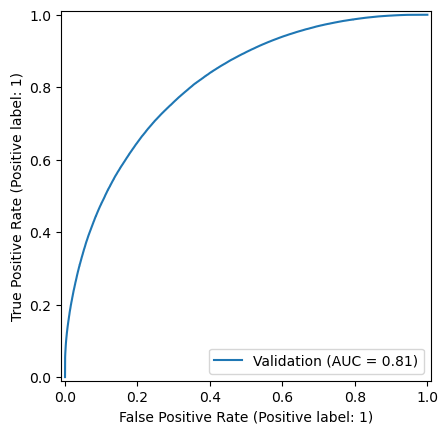

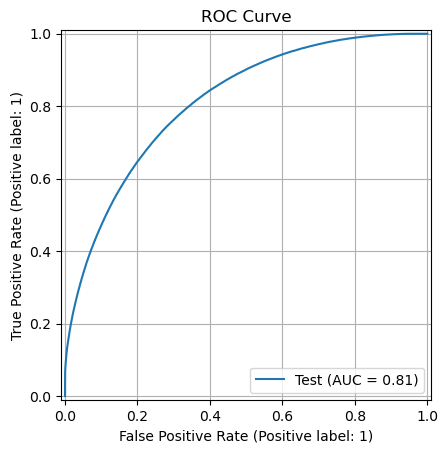

In [11]:
# ROC curve (Validation vs Test)
plt.figure(figsize=(7, 5))
RocCurveDisplay.from_predictions(y_val, val_proba, name="Validation")
RocCurveDisplay.from_predictions(y_test, test_proba, name="Test")
plt.title("ROC Curve")
plt.grid(True)
plt.show()


<Figure size 700x500 with 0 Axes>

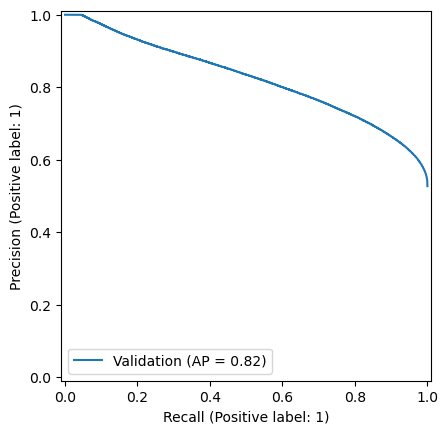

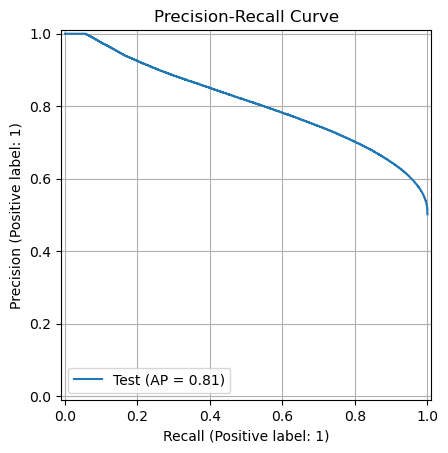

In [12]:
# Precision-Recall curve (Validation vs Test)
plt.figure(figsize=(7, 5))
PrecisionRecallDisplay.from_predictions(y_val, val_proba, name="Validation")
PrecisionRecallDisplay.from_predictions(y_test, test_proba, name="Test")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()


## 5) Quick feature importance (sanity check)
This is a quick diagnostic to verify the model uses sensible signals. We'll use SHAP later for deeper inspection.

In [13]:
importances = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=False)
importances

user_like_rate        0.310462
movie_like_rate       0.213590
user_mean_rating      0.176410
movie_mean_rating     0.160800
movie_n_ratings       0.011652
year                  0.010872
user_n_ratings        0.010757
Children              0.008843
Romance               0.007834
Crime                 0.007638
Musical               0.006887
Horror                0.006138
Sci-Fi                0.005795
Adventure             0.005793
Mystery               0.005630
Action                0.005591
Film-Noir             0.005148
Fantasy               0.005085
IMAX                  0.005038
Animation             0.004566
Comedy                0.004545
Drama                 0.004528
Thriller              0.004461
Western               0.004246
War                   0.004113
Documentary           0.003575
(no genres listed)    0.000000
dtype: float32

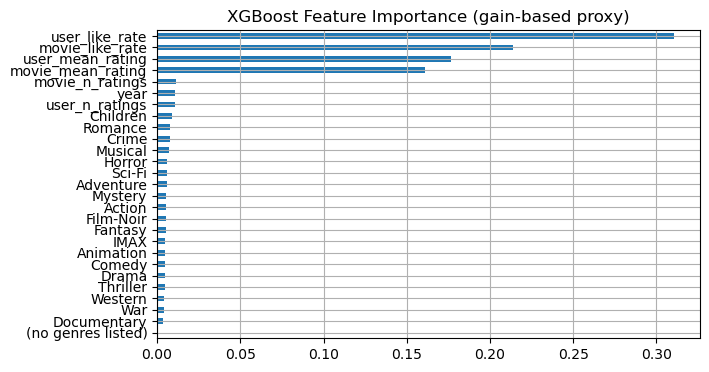

In [14]:
plt.figure(figsize=(7, 4))
importances.sort_values().plot(kind="barh")
plt.title("XGBoost Feature Importance (gain-based proxy)")
plt.grid(True)
plt.show()


## 6) Persist artifacts
We save the trained baseline model so it can be loaded in downstream notebooks.

In [15]:
joblib.dump(model, "../artifacts/baseline_xgb_model.pkl")
print("Saved: baseline_xgb_model.pkl")


Saved: baseline_xgb_model.pkl
